#Project for CS235
Name: Fengchun Fan\
 SID: 862134815

#Prepare the Dataset

We will be using the Wisconsin Breast Cancer Diagnostic dataset from the UCI data repository: \
https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic

Install the ucimlrepo package

In [ ]:
pip install ucimlrepo

Import the dataset into notebook

In [ ]:
from ucimlrepo import fetch_ucirepo
# fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

In [ ]:
# data (as pandas dataframes)
# since it is unsupervised technique, we don't need y dataset (labels)
X = breast_cancer_wisconsin_diagnostic.data.features

Get the needed libraries

In [ ]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import sys
import random
from sklearn.model_selection import train_test_split

# Phase 2 - Unsupervised Techniques [50/100]


For the performance of our algorithm, we need to run the clustering algorithm 10 times with different random initializations and report the average +/- standard deviation of the Silhouette coefficient.

We will be using existing Silhouette implementation of Sklearn, reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

In [ ]:
# import the function
from sklearn.metrics import silhouette_score

## 1. k-means clustering [10pts]


In this section, we will implement Lloyd's algorithm for k-means clustering and
the k-means++ initialization algorithm. \
The program should have option to use fully random or k-means ++ initialization.\
For distance between data points, we will be using existing euclidean distance calculation function, which is math.dist() method. \
Reference: https://www.w3schools.com/python/ref_math_dist.asp \
High level idea referenced to lecture slide 07a-unsupervised, slide 15:\
We will start by initializing the cluster centroids, meaning, pick k points at random and set as centroids representing each cluster.\
Another way of initializing centroid, is called k-means++, we will choose one point randomly as centroid, calculate the distance with each point to their closet centroid, and use that distance^2 as probability of chosing that point. Repeat until finished finding k centroids.\
Next, we will assign each point to its nearest centroid, give them label same as that centroid's index.\
After assignments, compute new cluster centroids as mean of all points in cluster.\
Repeat until cluster assignments don't change.

In [ ]:
class Kmeans:
  def __init__(self, k = None, initial_mode = None):
    # get the number of cluster
    self.k = k
    # get the initialization method
    self.initial_mode = initial_mode
    # the list of centroids, cannot be indexes, must be legit rows
    self.centroids = []
    # the final labels assigned to each data point, needed for evaluation
    self.labels = []

  # main driver function, input dataset
  # in unsupervised learning, don't split training/testing dataset
  def fit(self, X):
    # get number of datapoints
    n_samples, _ = X.shape

    # pick k initial cluster centroids
    # if mode is 1, that means completely random pick k points
    if self.initial_mode == 1:
      # using existing random function to select k non-repeat data point index from given np range list
      # reference: https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html
      # since we don't want repeat, we will select non-replacement, output k points from 0 to n_samples - 1
      centroids_indexes = np.random.choice(n_samples, size = self.k, replace = False)
      # append the actual rows into centroids list
      for i in range (self.k):
        self.centroids.append(X.iloc[centroids_indexes[i]])
    # if mode is 2, that means k-means ++ initialization
    elif self.initial_mode == 2:
      self.centroids = self.kpp_initialization(X)

    # get labels according to the chosen centroids
    curr_labels = self.generate_labels(X)
    # while we still can see updates
    # chose the new centroid, and repeat process
    while curr_labels != self.labels:
      # replace globally saved labels[] with curr_labels[]
      self.labels = curr_labels
      # get new centroids
      self.centroids = self.generate_centroids(X)
      # generate new labels based on the newly generated centroids
      curr_labels = self.generate_labels(X)

  # function to perform k-means++ initialization
  # we will first start a random point and declare it centroid
  # compute distance for all remaining datapoint
  # Select a random point with probability proportional to D(xj, c1)2
  def kpp_initialization(self, X):
    new_centroids = []
    # get number of datapoints
    n_samples, _ = X.shape
    # start with selecting a random centroid index
    initial_centroid = np.random.choice(n_samples, replace = False)
    new_centroids.append(X.iloc[initial_centroid])
    # we have chosen one centroid, choose the remaining ones
    for index in range (self.k - 1):
      # store distance of each datapoint to its nearest centroid
      dist = []
      dist_sum = 0
      # if selected already, the min distance will be 0 and will not be selected anyways
      for i in range (n_samples):
        min = float('inf')
        # find the distance between current datapoint and its closet centroid
        for j in range (len(new_centroids)):
          curr_dist = math.dist(X.iloc[i], new_centroids[j])
          # keep the smallest distance
          if curr_dist < min:
            min = curr_dist
        # update with chosen final dist
        dist.append(min * min)
        dist_sum += (min * min)
      # normalize the distance array, thus all points add up to 1, serve as probability
      for pos in range(len(dist)):
        dist[pos] = dist[pos]/dist_sum
      # choose a new random centroid with dist array as probability
      new_centroid = np.random.choice(n_samples, p = dist, replace = False)
      new_centroids.append(X.iloc[new_centroid])
    return new_centroids

  # return a list of new centroids
  # having the information of newly created cluster
  # generate new centroid as mean of all points in the cluster
  # idea is, for each centroid, count total number of datapoints with curr label
  # combined all columns of the datapoints together, then divide by count
  def generate_centroids(self, X):
    new_centroids = []
    # get number of datapoints
    n_samples, _ = X.shape
    # loop through every centroid
    for j in range(len(self.centroids)):
      # base cases
      num_points = 0
      combined_data_points = 0
      # loop through each data points
      for i in range (n_samples):
        # if current data point has label of current centroid
        if(self.labels[i] == j):
          # add in all columns of values
          combined_data_points += X.iloc[i]
          # increment count
          num_points += 1
      new_centroids.append(combined_data_points/num_points)
    return new_centroids


  # return a list of labels corresponding by each data points
  # idea is to match current datapoint to the closet centroid
  def generate_labels(self, X):
    curr_labels = []
    # get number of datapoints
    n_samples, _ = X.shape
    # loop through all datapoints in X
    for i in range (n_samples):
      min = float('inf')
      chosen_index = None
      # check current datapoint's distance with each centroid
      # chose the closet centroid, and label current datapoint to that correspoinding centroid's index
      for j in range(len(self.centroids)):
        if math.dist(X.iloc[i], self.centroids[j]) < min:
          min = math.dist(X.iloc[i], self.centroids[j])
          chosen_index = j
      # append current datapoint's chosen label
      curr_labels.append(chosen_index)
    return curr_labels


  # helper function to extract labels
  def get_labels(self):
    return self.labels

###Get performance and plot

####Fully random initialization

In [ ]:
# k = 1
# we are not able to get a Silhouette coefficient for k == 1
kms_1_1_mean = 0
kms_1_1_std = 0

In [ ]:
# k = 2
scores = []
for i in range(10):
  km = Kmeans(2, 1)
  km.fit(X)
  scores.append(silhouette_score(X, km.get_labels()))
kms_2_1_mean = np.mean(scores)
kms_2_1_std = np.std(scores)

In [ ]:
# k = 3
scores = []
for i in range(10):
  km = Kmeans(3, 1)
  km.fit(X)
  scores.append(silhouette_score(X, km.get_labels()))
kms_3_1_mean = np.mean(scores)
kms_3_1_std = np.std(scores)

In [ ]:
# k = 4
scores = []
for i in range(10):
  km = Kmeans(4, 1)
  km.fit(X)
  scores.append(silhouette_score(X, km.get_labels()))
kms_4_1_mean = np.mean(scores)
kms_4_1_std = np.std(scores)

In [ ]:
# k = 5
scores = []
for i in range(10):
  km = Kmeans(5, 1)
  km.fit(X)
  scores.append(silhouette_score(X, km.get_labels()))
kms_5_1_mean = np.mean(scores)
kms_5_1_std = np.std(scores)

####k-means++ initialization

In [ ]:
# k = 1
# we are not able to get a Silhouette coefficient for k == 1
kms_1_2_mean = 0
kms_1_2_std = 0

In [ ]:
# k = 2
scores = []
for i in range(10):
  km = Kmeans(2, 2)
  km.fit(X)
  scores.append(silhouette_score(X, km.get_labels()))
kms_2_2_mean = np.mean(scores)
kms_2_2_std = np.std(scores)

In [ ]:
# k = 3
scores = []
for i in range(10):
  km = Kmeans(3, 2)
  km.fit(X)
  scores.append(silhouette_score(X, km.get_labels()))
kms_3_2_mean = np.mean(scores)
kms_3_2_std = np.std(scores)

In [ ]:
# k = 4
scores = []
for i in range(10):
  km = Kmeans(4, 2)
  km.fit(X)
  scores.append(silhouette_score(X, km.get_labels()))
kms_4_2_mean = np.mean(scores)
kms_4_2_std = np.std(scores)

In [ ]:
# k = 5
scores = []
for i in range(10):
  km = Kmeans(5, 2)
  km.fit(X)
  scores.append(silhouette_score(X, km.get_labels()))
kms_5_2_mean = np.mean(scores)
kms_5_2_std = np.std(scores)

####Plot

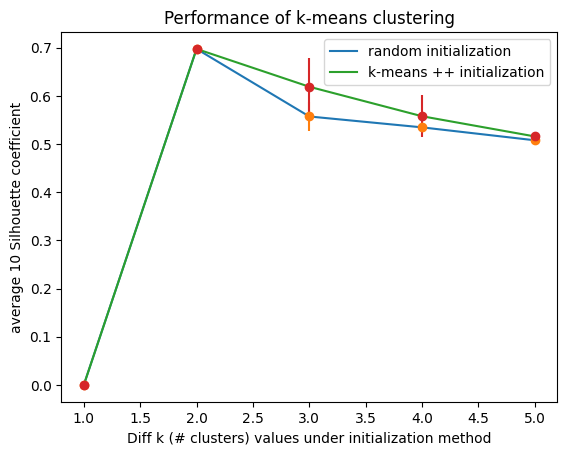

In [ ]:
x_axis = [1, 2, 3, 4, 5]
# random initialization
rand_axis = [kms_1_1_mean, kms_2_1_mean, kms_3_1_mean, kms_4_1_mean, kms_5_1_mean]
rand_err_axis = [kms_1_1_std, kms_2_1_std, kms_3_1_std, kms_4_1_std, kms_5_1_std]
# k-means ++ initialization
kpp_axis = [kms_1_2_mean, kms_2_2_mean, kms_3_2_mean, kms_4_2_mean, kms_5_2_mean]
kpp_err_axis = [kms_1_2_std, kms_2_2_std, kms_3_2_std, kms_4_2_std, kms_5_2_std]
# plot the graph
plt.plot(x_axis, rand_axis, label = "random initialization")
plt.errorbar(x_axis, rand_axis, yerr = rand_err_axis, fmt ='o')
plt.plot(x_axis, kpp_axis, label = "k-means ++ initialization")
plt.errorbar(x_axis, kpp_axis, yerr = kpp_err_axis, fmt ='o')
plt.xlabel("Diff k (# clusters) values under initialization method")
plt.ylabel("average 10 Silhouette coefficient")
plt.title("Performance of k-means clustering")
plt.legend()
plt.show()

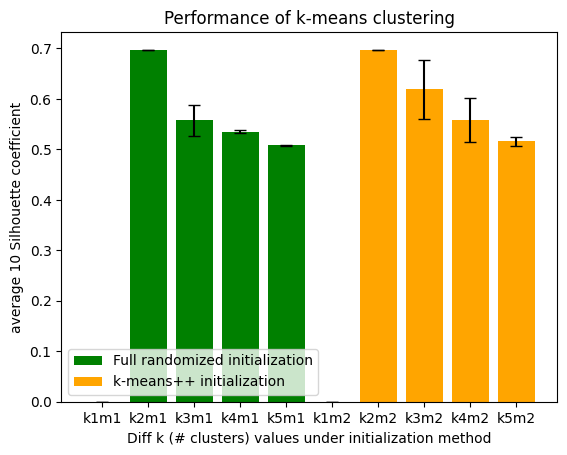

In [ ]:
# random initialization
plt.bar("k1m1", kms_1_1_mean, yerr = kms_1_1_std, color = "green", capsize = 4, label = "Full randomized initialization")
plt.bar("k2m1", kms_2_1_mean, yerr = kms_2_1_std, color = "green", capsize = 4)
plt.bar("k3m1", kms_3_1_mean, yerr = kms_3_1_std, color = "green", capsize = 4)
plt.bar("k4m1", kms_4_1_mean, yerr = kms_4_1_std, color = "green", capsize = 4)
plt.bar("k5m1", kms_5_1_mean, yerr = kms_5_1_std, color = "green", capsize = 4)
# k-means ++ initialization
plt.bar("k1m2", kms_1_2_mean, yerr = kms_1_2_std, color = "orange", capsize = 4, label = "k-means++ initialization")
plt.bar("k2m2", kms_2_2_mean, yerr = kms_2_2_std, color = "orange", capsize = 4)
plt.bar("k3m2", kms_3_2_mean, yerr = kms_3_2_std, color = "orange", capsize = 4)
plt.bar("k4m2", kms_4_2_mean, yerr = kms_4_2_std, color = "orange", capsize = 4)
plt.bar("k5m2", kms_5_2_mean, yerr = kms_5_2_std, color = "orange", capsize = 4)
# plot
plt.xlabel("Diff k (# clusters) values under initialization method")
plt.ylabel("average 10 Silhouette coefficient")
plt.title("Performance of k-means clustering")
plt.legend()
plt.show()

##2. Density-based clustering with DBSCAN [15pts]


In this section, we will implement the DBSCAN algorithm \
The high level idea of the algorithm is referenced to slide 10 of lecture slide 07b-unsupervised: \


In [ ]:
class DBScan:
  # get the Eps and MinPts value from user
  def __init__(self, Eps = None, MinPts = None):
    # Maximum radius of the neighborhood
    self.Eps = Eps
    # Minimum number of points in an Eps neighborhood of that point
    self.MinPts = MinPts
    # the final labels assigned to each data point, needed for evaluation
    self.labels = []

  # main driver function
  def fit(self, X):
    # all points are initialized as unvisited
    # we can achieve this by assigning labels to 0 for all points
    n_samples, _ = X.shape
    self.initialize_labels(X)
    curr_cluster_index = 0
    # check if all data points are visited
    # end while loop if all labels are non-zero
    while not self.all_visited():
      # update the current cluster index
      # get a list of all indexes that has 0 as label
      candidates = self.get_candidates()
      # select a point p at random
      p = np.random.choice(candidates)
      # left = self.get_left()
      # print("current p: ", p, " , there are ", left, " points left")
      # p = np.random.choice(n_samples)
      N = self.get_neighborhood(p, X)
      # check if p is a core point by checking if
      # its Eps-neighborhood has at least MinPts points
      if len(N) >= self.MinPts:
        # increment the current cluster index
        curr_cluster_index += 1
        # mark p as visited, and assign to this cluster
        self.labels[p] = curr_cluster_index
        # a list to track all seen datapoints
        seen = []
        # while loop to check each point q in N
        # mark q as visited
        while N:
          # starting with the first element
          q = N[0]
          # pop the first element
          N.pop(0)
          # check if q is unvisited or is noise, assign it to current cluster
          if self.labels[q] == 0:
            self.labels[q] = curr_cluster_index
          # check the neighborhood of q
          curr_N = self.get_neighborhood(q, X)
          # if the size of this neighborhood is >= MinPts, merge it with N
          if len(curr_N) >= self.MinPts:
            # merge, ensure no duplicate points, and no seen points
            for index in range(len(curr_N)):
              if curr_N[index] not in seen:
                N.append(curr_N[index])
                seen.append(curr_N[index])
      else:
        # mark p as noise (also a visited label)
        self.labels[p] = -1

  # helper function, return the neighborhood of selected p
  def get_neighborhood(self, p, X):
    n_samples, _ = X.shape
    # remove all points stored in previous N
    N = []
    for i in range (n_samples):
      # check if the euclidean distance between X[p] and X[i] is <= eps
      if (math.dist(X.iloc[p], X.iloc[i]) <= self.Eps):
        # push current datapoint's index into N
        N.append(i)
    # return neighborhood
    return N

  # helper function, check how many 0s are left
  def get_left(self):
    count = 0
    for i in range (len(self.labels)):
      if self.labels[i] == 0:
        count += 1
    return count

  # helper function, loop through the label
  # store the index of datapoints that has 0 as label
  def get_candidates(self):
    candidates = []
    for i in range (len(self.labels)):
      if self.labels[i] == 0:
        candidates.append(i)
    return candidates

  # helper function, return true only if all data points are visited
  # i.e all labels are non-zero
  def all_visited(self):
    for i in range (len(self.labels)):
      if self.labels[i] == 0:
        return False
    return True

  # function to return the currently assigned labels (defined clusters)
  def get_labels(self):
    return self.labels

  # initialize self.labels to all 0 (unvisited)
  def initialize_labels(self, X):
    num_samples, _ = X.shape
    for i in range (num_samples):
      self.labels.append(0)

###Performance and Plot

As Professor has announced, the Eps value proposed in the project description will not work properly, and it is indeed the case, after testing with Eps = 0.1, I only end up with single cluster of noise datapoints.\
Trying out our own Eps value, I will be using Eps = 100, and Eps = 200 after several testings.

####Get mean and std for MinPts = [5, 10, 15, 20], Eps = [100, 200]

In [ ]:
# Eps = 100, MinPts = 5
scores = []
for i in range(10):
  db = DBScan(100, 5)
  db.fit(X)
  scores.append(silhouette_score(X, db.get_labels()))
db_100_5_mean = np.mean(scores)
db_100_5_std = np.std(scores)

In [ ]:
# Eps = 100, MinPts = 10
scores = []
for i in range(10):
  db = DBScan(100, 10)
  db.fit(X)
  scores.append(silhouette_score(X, db.get_labels()))
db_100_10_mean = np.mean(scores)
db_100_10_std = np.std(scores)

In [ ]:
# Eps = 100, MinPts = 15
scores = []
for i in range(10):
  db = DBScan(100, 15)
  db.fit(X)
  scores.append(silhouette_score(X, db.get_labels()))
db_100_15_mean = np.mean(scores)
db_100_15_std = np.std(scores)

In [ ]:
# Eps = 100, MinPts = 20
scores = []
for i in range(10):
  db = DBScan(100, 20)
  db.fit(X)
  scores.append(silhouette_score(X, db.get_labels()))
db_100_20_mean = np.mean(scores)
db_100_20_std = np.std(scores)

In [ ]:
# Eps = 200, MinPts = 5
scores = []
for i in range(10):
  db = DBScan(200, 5)
  db.fit(X)
  scores.append(silhouette_score(X, db.get_labels()))
db_200_5_mean = np.mean(scores)
db_200_5_std = np.std(scores)

In [ ]:
# Eps = 200, MinPts = 10
scores = []
for i in range(10):
  db = DBScan(200, 10)
  db.fit(X)
  scores.append(silhouette_score(X, db.get_labels()))
db_200_10_mean = np.mean(scores)
db_200_10_std = np.std(scores)

In [ ]:
# Eps = 200, MinPts = 15
scores = []
for i in range(10):
  db = DBScan(200, 15)
  db.fit(X)
  scores.append(silhouette_score(X, db.get_labels()))
db_200_15_mean = np.mean(scores)
db_200_15_std = np.std(scores)

In [ ]:
# Eps = 200, MinPts = 20
scores = []
for i in range(10):
  db = DBScan(200, 20)
  db.fit(X)
  scores.append(silhouette_score(X, db.get_labels()))
db_200_20_mean = np.mean(scores)
db_200_20_std = np.std(scores)

####Plot

Std/error bar is added, but appearantly it is pretty small so not very obvious

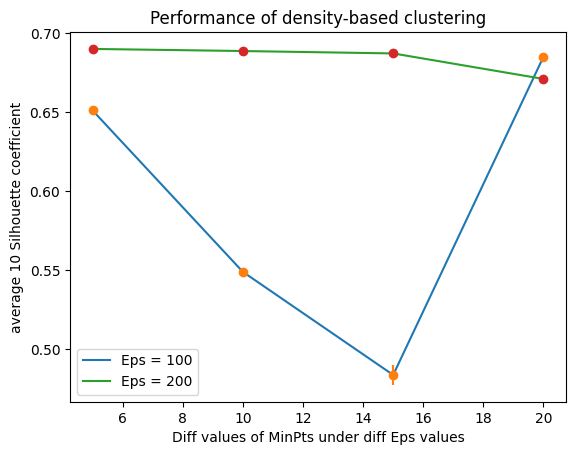

In [ ]:
x_axis = [5, 10, 15, 20]
# Eps = 100
eps_100_axis = [db_100_5_mean, db_100_10_mean, db_100_15_mean, db_100_20_mean]
eps_100_err_axis = [db_100_5_std, db_100_10_std, db_100_15_std, db_100_20_std]
# Eps = 200
eps_200_axis = [db_200_5_mean, db_200_10_mean, db_200_15_mean, db_200_20_mean]
eps_200_err_axis = [db_200_5_std, db_200_10_std, db_200_15_std, db_200_20_std]
# plot the graph
plt.plot(x_axis, eps_100_axis, label = "Eps = 100")
plt.errorbar(x_axis, eps_100_axis, yerr = eps_100_err_axis, fmt ='o')
plt.plot(x_axis, eps_200_axis, label = "Eps = 200")
plt.errorbar(x_axis, eps_200_axis, yerr = eps_200_err_axis, fmt ='o')
plt.xlabel("Diff values of MinPts under diff Eps values")
plt.ylabel("average 10 Silhouette coefficient")
plt.title("Performance of density-based clustering")
plt.legend()
plt.show()

In [ ]:
eps_100_err_axis

[1.1102230246251565e-16, 0.0016787628644228136, 0.006310896614712011, 0.0]

In [ ]:
eps_200_err_axis

[1.1102230246251565e-16, 0.0, 0.0, 1.1102230246251565e-16]

## 3. Graph-based clustering with Spectral Clustering [10pts]


In this section, implement the version of Spectral Clustering (“Unnormalized spectral clustering”) and Gaussian similarity function.\
Got help from youtube video: https://www.youtube.com/watch?v=5FQfEjDic84, to better understand the concept of unnormalized spectral clustering.\
The high level idea of the algorithm is referenced to page 6 of paper: "A tutorial on spectral clustering": \
We need to first construct a similarity graph based on Gaussian similarity function, and make W its weighted adjacency matrix. \
Next we will compute the unnormalized Laplacian L, by finding diagonal matrix D and minus W. \
Then we will compute first k eigenvectors u1, .. uk of L, first k means vectors with highest k eigenvalues. \
Combine the k eigenvectors (columns) and form matrix U. This will be the end of algorithm, and we will extract U. \
Lastly, apply k-means clustering on the newly constructed matrix and find the labels.

In [ ]:
class Spectral:
  def __init__(self, k = None, sigma = None):
    # number of clusters
    self.k = k
    # used to calculate Gaussian similarity between datapoints
    # control the width of the neighborhood
    self.sigma = sigma
    # weighted adjacency matrix, size is n_samples * n_samples
    self.W = []
    # unnormalized Laplacian L
    self.L = []
    # matrix containing k eigenvectors, n * k in shape
    self.U = []

  # main driver function
  def fit(self, X):
    # construct the similarity matrix
    self.generate_W(X)
    # compute the unnormalized Laplacian L
    self.compute_L(X)
    # compute first k eigenvectors of L
    # and reconstruct them to U
    # reference: https://numpy.org/doc/stable/reference/generated/numpy.linalg.eigh.html
    self.generate_U(X)

  # helper function to return the output matrix U
  def get_U(self):
    # make sure it is in pandas dataframe format
    return pd.DataFrame(self.U)

  # helper function
  # generate k eigenvectors using library: https://numpy.org/doc/stable/reference/generated/numpy.linalg.eigh.html
  # because we made sure that input L is symatric (diagonal) matrix, thus we can use eigh instead of eig
  # big advantage is that eigenvectors came in order in the first place
  # pick k smallest eigenvalue, then append their corresponding eigenvectors to U
  def generate_U(self, X):
    eigenvalues, eigenvectors = np.linalg.eigh(self.L)
    # print("eigenvalues:", eigenvalues)
    # here, eigenvalues is sorted in ascending order, then so will be the eigenvectors
    # thus we will be taking first k eigenvectors
    # this append as rows, wrong
    #for index in range (self.k):
    #  self.U.append(eigenvectors[:, self.k])
    # directly take first k columns and form U, shape of U: n * k
    self.U = eigenvectors[:, :self.k]

  # helper function, compute the unnormalized graph Laplacian L
  # equaiton: L = D - W
  def compute_L(self, X):
    # get number of data points
    n_samples, _ = X.shape
    # first find degree matrix D
    # degree matrix is a diagonal matrix with degrees d1 ... dn on the diagonal
    # initialize it as all 0s
    D = np.zeros((n_samples, n_samples))
    for i in range (n_samples):
      total = 0
      # loop through the row to add up all the sum
      for j in range (n_samples):
        total += self.W[i][j]
      # update degree matrix D after going through the row
      D[i][i] = total
    # apply formula after constructing D to find L
    self.L = D - self.W

  # helper function, generate adjacency matrix based on input dataset X
  # adjacency matrix is n * n, a point [i][j] indicates the similarity between X[i] and X[j]
  # similarity is calculated through Guaussian similarity function
  def generate_W(self, X):
    # get number of data points
    n_samples, _ = X.shape
    # initialize W
    curr_W = np.zeros((n_samples, n_samples))
    # for each data point
    for i in range (n_samples):
      # loop through entire dataset
      for j in range (n_samples):
        # calculate Guassian similarity between current datapoint and target datapoint
        sim = np.exp(-np.square(math.dist(X.iloc[i], X.iloc[j])) / (2 * self.sigma * self.sigma))
        curr_W[i][j] = sim
    # replace global W with current W
    self.W = curr_W

###Performance and Plots

####Eps = 0.1

In [ ]:
# k = 1
# we are not able to get a Silhouette coefficient for k == 1
sp_1_01_mean = 0
sp_1_01_std = 0

In [ ]:
# k = 2
scores = []
for i in range(10):
  sp = Spectral(2, 0.1)
  sp.fit(X)
  new_X = sp.get_U()
  # k = 2, mode is kmeans++
  km = Kmeans(2, 2)
  km.fit(new_X)
  scores.append(silhouette_score(new_X, km.get_labels()))
sp_2_01_mean = np.mean(scores)
sp_2_01_std = np.std(scores)

In [ ]:
# k = 3
scores = []
for i in range(10):
  sp = Spectral(3, 0.1)
  sp.fit(X)
  new_X = sp.get_U()
  # k = 3, mode is kmeans++
  km = Kmeans(3, 2)
  km.fit(new_X)
  scores.append(silhouette_score(new_X, km.get_labels()))
sp_3_01_mean = np.mean(scores)
sp_3_01_std = np.std(scores)

In [ ]:
# k = 4
scores = []
for i in range(10):
  sp = Spectral(4, 0.1)
  sp.fit(X)
  new_X = sp.get_U()
  # k = 4, mode is kmeans++
  km = Kmeans(4, 2)
  km.fit(new_X)
  scores.append(silhouette_score(new_X, km.get_labels()))
sp_4_01_mean = np.mean(scores)
sp_4_01_std = np.std(scores)

In [ ]:
# k = 5
scores = []
for i in range(10):
  sp = Spectral(5, 0.1)
  sp.fit(X)
  new_X = sp.get_U()
  # k = 5, mode is kmeans++
  km = Kmeans(5, 2)
  km.fit(new_X)
  scores.append(silhouette_score(new_X, km.get_labels()))
sp_5_01_mean = np.mean(scores)
sp_5_01_std = np.std(scores)

####Eps = 1

In [ ]:
# k = 1
# we are not able to get a Silhouette coefficient for k == 1
sp_1_1_mean = 0
sp_1_1_std = 0

In [ ]:
# k = 2
scores = []
for i in range(10):
  sp = Spectral(2, 1)
  sp.fit(X)
  new_X = sp.get_U()
  # k = 2, mode is kmeans++
  km = Kmeans(2, 2)
  km.fit(new_X)
  scores.append(silhouette_score(new_X, km.get_labels()))
sp_2_1_mean = np.mean(scores)
sp_2_1_std = np.std(scores)

In [ ]:
# k = 3
scores = []
for i in range(10):
  sp = Spectral(3, 1)
  sp.fit(X)
  new_X = sp.get_U()
  # k = 3, mode is kmeans++
  km = Kmeans(3, 2)
  km.fit(new_X)
  scores.append(silhouette_score(new_X, km.get_labels()))
sp_3_1_mean = np.mean(scores)
sp_3_1_std = np.std(scores)

In [ ]:
# k = 4
scores = []
for i in range(10):
  sp = Spectral(4, 1)
  sp.fit(X)
  new_X = sp.get_U()
  # k = 4, mode is kmeans++
  km = Kmeans(4, 2)
  km.fit(new_X)
  scores.append(silhouette_score(new_X, km.get_labels()))
sp_4_1_mean = np.mean(scores)
sp_4_1_std = np.std(scores)

In [ ]:
# k = 5
scores = []
for i in range(10):
  sp = Spectral(5, 1)
  sp.fit(X)
  new_X = sp.get_U()
  # k = 5, mode is kmeans++
  km = Kmeans(5, 2)
  km.fit(new_X)
  scores.append(silhouette_score(new_X, km.get_labels()))
sp_5_1_mean = np.mean(scores)
sp_5_1_std = np.std(scores)

####Eps = 10

In [ ]:
# k = 1
# we are not able to get a Silhouette coefficient for k == 1
sp_1_10_mean = 0
sp_1_10_std = 0

In [ ]:
# k = 2
scores = []
for i in range(10):
  sp = Spectral(2, 10)
  sp.fit(X)
  new_X = sp.get_U()
  # k = 2, mode is kmeans++
  km = Kmeans(2, 2)
  km.fit(new_X)
  scores.append(silhouette_score(new_X, km.get_labels()))
sp_2_10_mean = np.mean(scores)
sp_2_10_std = np.std(scores)

In [ ]:
# k = 3
scores = []
for i in range(10):
  sp = Spectral(3, 10)
  sp.fit(X)
  new_X = sp.get_U()
  # k = 3, mode is kmeans++
  km = Kmeans(3, 2)
  km.fit(new_X)
  scores.append(silhouette_score(new_X, km.get_labels()))
sp_3_10_mean = np.mean(scores)
sp_3_10_std = np.std(scores)

In [ ]:
# k = 4
scores = []
for i in range(10):
  sp = Spectral(4, 10)
  sp.fit(X)
  new_X = sp.get_U()
  # k = 4, mode is kmeans++
  km = Kmeans(4, 2)
  km.fit(new_X)
  scores.append(silhouette_score(new_X, km.get_labels()))
sp_4_10_mean = np.mean(scores)
sp_4_10_std = np.std(scores)

In [ ]:
# k = 5
scores = []
for i in range(10):
  sp = Spectral(5, 10)
  sp.fit(X)
  new_X = sp.get_U()
  # k = 5, mode is kmeans++
  km = Kmeans(5, 2)
  km.fit(new_X)
  scores.append(silhouette_score(new_X, km.get_labels()))
sp_5_10_mean = np.mean(scores)
sp_5_10_std = np.std(scores)

####Plot

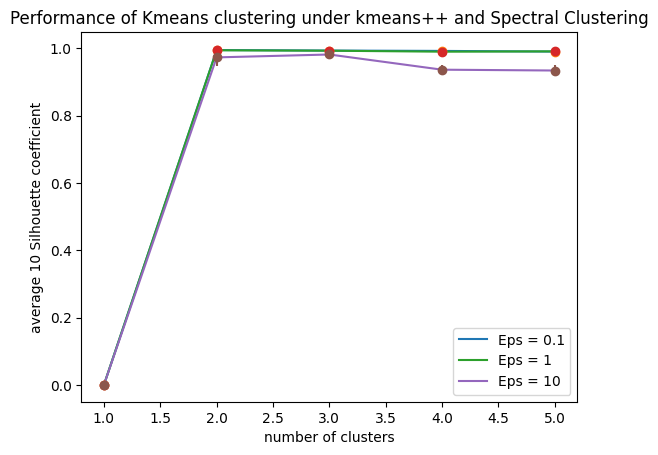

In [ ]:
x_axis = [1, 2, 3, 4, 5]
# Eps = 0.1
sp_01_axis = [sp_1_01_mean, sp_2_01_mean, sp_3_01_mean, sp_4_01_mean, sp_5_01_mean]
sp_01_err_axis = [sp_1_01_std, sp_2_01_std, sp_3_01_std, sp_4_01_std, sp_5_01_std]
# Eps = 1
sp_1_axis = [sp_1_1_mean, sp_2_1_mean, sp_3_1_mean, sp_4_1_mean, sp_5_1_mean]
sp_1_err_axis = [sp_1_1_std, sp_2_1_std, sp_3_1_std, sp_4_1_std, sp_5_1_std]
# Eps = 10
sp_10_axis = [sp_1_10_mean, sp_2_10_mean, sp_3_10_mean, sp_4_10_mean, sp_5_10_mean]
sp_10_err_axis = [sp_1_10_std, sp_2_10_std, sp_3_10_std, sp_4_10_std, sp_5_10_std]
# plot the graph
plt.plot(x_axis, sp_01_axis, label = "Eps = 0.1")
plt.errorbar(x_axis, sp_01_axis, yerr = sp_01_err_axis, fmt ='o')
plt.plot(x_axis, sp_1_axis, label = "Eps = 1")
plt.errorbar(x_axis, sp_1_axis, yerr = sp_1_err_axis, fmt ='o')
plt.plot(x_axis, sp_10_axis, label = "Eps = 10")
plt.errorbar(x_axis, sp_10_axis, yerr = sp_10_err_axis, fmt ='o')
plt.xlabel("number of clusters")
plt.ylabel("average 10 Silhouette coefficient")
plt.title("Performance of Kmeans clustering under kmeans++ and Spectral Clustering")
plt.legend()
plt.show()

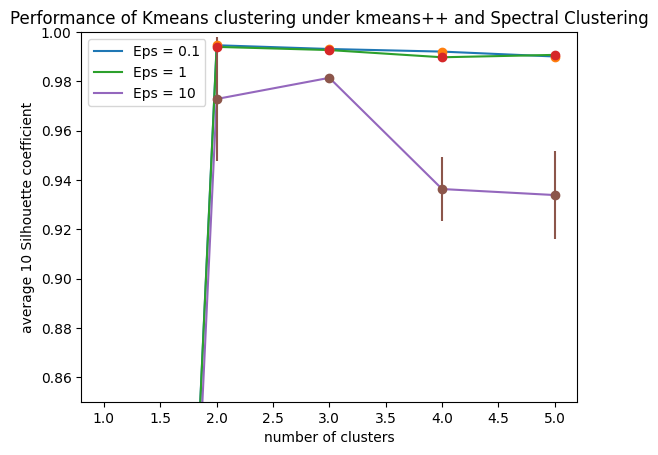

In [ ]:
# zoomed in version that focus on y [0.85, 1]
x_axis = [1, 2, 3, 4, 5]
# Eps = 0.1
sp_01_axis = [sp_1_01_mean, sp_2_01_mean, sp_3_01_mean, sp_4_01_mean, sp_5_01_mean]
sp_01_err_axis = [sp_1_01_std, sp_2_01_std, sp_3_01_std, sp_4_01_std, sp_5_01_std]
# Eps = 1
sp_1_axis = [sp_1_1_mean, sp_2_1_mean, sp_3_1_mean, sp_4_1_mean, sp_5_1_mean]
sp_1_err_axis = [sp_1_1_std, sp_2_1_std, sp_3_1_std, sp_4_1_std, sp_5_1_std]
# Eps = 10
sp_10_axis = [sp_1_10_mean, sp_2_10_mean, sp_3_10_mean, sp_4_10_mean, sp_5_10_mean]
sp_10_err_axis = [sp_1_10_std, sp_2_10_std, sp_3_10_std, sp_4_10_std, sp_5_10_std]
# plot the graph
plt.plot(x_axis, sp_01_axis, label = "Eps = 0.1")
plt.errorbar(x_axis, sp_01_axis, yerr = sp_01_err_axis, fmt ='o')
plt.plot(x_axis, sp_1_axis, label = "Eps = 1")
plt.errorbar(x_axis, sp_1_axis, yerr = sp_1_err_axis, fmt ='o')
plt.plot(x_axis, sp_10_axis, label = "Eps = 10")
plt.errorbar(x_axis, sp_10_axis, yerr = sp_10_err_axis, fmt ='o')
plt.xlabel("number of clusters")
plt.ylabel("average 10 Silhouette coefficient")
plt.title("Performance of Kmeans clustering under kmeans++ and Spectral Clustering")
plt.ylim(0.85, 1)
plt.legend()
plt.show()

## 4. Anomaly detection with the Isolation Forest [15pts]


In this section, we should implement the Isolation Forest anomaly detection
algorithm as described in the original paper. \
My code uses: https://ieeexplore.ieee.org/abstract/document/4781136 as reference \
The high level idea is: \
Build isolation trees using partial training set \
We will pass in the training dataset, create a subtraining dataset of size 256 as described in paper, and set the height limit of the tree \
We will construct 100 trees in the forest as suggested in the paper \
Since we are doing a decision tree, and split into left and right part, we will create a node class to have the following 4 attributes: left node, right node, random attribute and a random value in range of max/min value among all values in dataset under that attribute \
Now during tree construction, we will randomly generate p and q in each height of the tree, recursively build the tree up and increment height counter. We will end when height reaches limit or dataset is splited enough to 1 datapoint left \
Pass test instances through isolation trees to obtain anomaly score for each instances \
For all data instances, we will push them into all trees in the forest and then retrieve the average score. To getting 1 score, we need to calculate the path length of the current data instance of the curr tree, idea is simple, just loop through the tree until hitting an ending node, and track the number of edges/depth curr data instance went through \
Lastly, apply the equations present in the paper to get average path length of unsuccessful search in BST with Harmonic number and Euler's constant, and find final anomaly score

In [ ]:
# class for TreeNodes
# modified based on my code in decision tree
# used for tree node as described in iTree
class Node():
  def __init__(self, left = None, right = None, SplitAtt = None, SplitValue = None):
    # left node pointer
    self.left = left
    # right node pointer
    self.right = right
    # randomly selected attribute/feature index
    self.SplitAtt = SplitAtt
    # randomly selected split point, either min or max from selected feature
    self.SplitValue = SplitValue

In [ ]:
class IsolationForest:
  def __init__(self, percentage = None):
    # iForest function
    # number of trees, default value as described in paper, or maybe just 10 for time issues
    self.num_trees = 100
    # subsampling size, default value as described in paper
    self.subsampling_size = 256
    # percentage of anomalies/outliers that need to be removed, q
    self.percentage = percentage
    # isolation forest of trees, p
    self.Forest = []
    # dictionary of the each pair of data point and its corresponding anomaly score
    self.score = {}

  # main driver function
  def fit(self, X):
    # construct isolation forest
    self.Forest = self.iForest(X)
    # get the anomaly score for each data instance
    self.get_scores(X)
    # create a new dataset X_new with percentage of top anomaly scored dataset being removed
    X_new = self.create_new_dataset(X)
    return X_new

  # helper function to create a new dataset with percentage of anomaly scored dataset dropped
  def create_new_dataset(self, X):
    n_samples, _ = X.shape
    X_new = []
    score_copy = self.score
    # define range
    ending_pt = int(n_samples * self.percentage / 100) + 1
    for i in range(ending_pt):
      # with help of chatgpt to retrieve first key of sorted dictionary
      score_copy.pop(next(iter(score_copy)))
    # append all keys/indexes in the remaining scoring array to the new dataframe
    for key in score_copy:
      X_new.append(X.iloc[key])
    return pd.DataFrame(X_new)

  # helper function to get the anomaly score for each data instance
  def get_scores(self, X):
    # find anomaly score for all data instances
    n_samples, _ = X.shape
    # loop through every data instance
    for i in range(n_samples):
      # initialize score
      curr_score = 0
      # loop through all isolation trees in the forest
      for j in range(len(self.Forest)):
        # get the score
        curr_score += self.PathLength(X, i, self.Forest[j], 0)
      # record the average score to the dictionary
      curr_score = curr_score / len(self.Forest)
      self.score[i] = curr_score
    # sort the dictionary based on anomaly score
    # reference https://realpython.com/sort-python-dictionary/
    # the higher anomaly scores will be placed front
    self.score = dict(sorted(self.score.items(), key=lambda item: item[1], reverse=True))

  # function to construct a forest of tree of number num_trees
  def iForest(self, X):
    Forest = []
    # as described in paper
    height_limit = math.ceil(math.log2(self.subsampling_size))
    for index in range(self.num_trees):
      # create a subsample of dataset X with subsampling size
      # using: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html
      X_sample = X.sample(n = self.subsampling_size)
      # apply tree construction algorithm
      Forest.append(self.iTree(X_sample, 0, height_limit))
    # return Forest
    return Forest

  # function to construct a tree
  # recursively partitioning the given training set until instances are isolated
  # or a specific tree height is reached
  # return the root node of the tree
  def iTree(self, X, curr_height, height_limit):
    # get number of samples and features remaining in the dataset
    n_samples, n_features = X.shape
    # if number of datapoints left is only 1, or we have reached the height limitation of tree, then stop
    # return None as null node
    if n_samples <= 1 or curr_height >= height_limit:
      return None
    else:
      # let Q be the list of attributes (indexes) in X
      Q = np.arange(n_features)
      # randomly select an attribute q from Q
      # reference to: https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html
      q = np.random.choice(Q)
      # select a random split point p from max and min values of attribute q in X
      p = self.get_p(X, q)
      # split the data set X based on split point p on feature index q
      X_l = X[X.iloc[:, q] < p]
      X_r = X[X.iloc[:, q] >= p]
      # verification:
      # print(curr_height, X_l.shape, X_r.shape)
      # recursively call TreeConstruction function
      return Node(self.iTree(X_l, curr_height + 1, height_limit),
                  self.iTree(X_r, curr_height + 1, height_limit),
                  q, p)

  # helper function, select a random split point p from max and min values of attribute q in X
  def get_p(self, X, q):
    n_samples, _ = X.shape
    # loop through dataset X to find max and min value
    max = -float("inf")
    min = float("inf")
    for i in range (n_samples):
      if X.iloc[i, q] > max:
        max = X.iloc[i, q]
      if X.iloc[i, q] < min:
        min = X.iloc[i, q]
    # random number reference to: https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html
    return np.random.uniform(min, max)

  # function to path length current test instance
  # idea is simple, we loop through the test instance through the tree, and find its average edge path until termination
  # at return, we will return the anomaly score
  def PathLength(self, X, index, treeNode, path_length):
    # if we have reached the termination site, return curr stored length
    if treeNode == None:
      n_samples, _ = X.shape
      # reference to page 3 of the paper, estimating average path length of unsuccessful search in BST
      # with Harmonic number and Euler's constant
      c_score = 2 * (np.log(n_samples - 1) + 0.5772156649) - (2 * (n_samples - 1) / (n_samples))
      # apply equation for anomaly score
      return 2 ** -(path_length / c_score)
    # else, retrieve the attribute index
    a = treeNode.SplitAtt
    if X.iloc[index, a] < treeNode.SplitValue:
      return self.PathLength(X, index, treeNode.left, path_length + 1)
    else:
      return self.PathLength(X, index, treeNode.right, path_length + 1)

### Get Performance

In [ ]:
# 0 % anomaly removed, k = 2
scores = []
for i in range(10):
  km = Kmeans(2, 2)
  km.fit(X)
  scores.append(silhouette_score(X, km.get_labels()))
IF_0_mean = np.mean(scores)
IF_0_std = np.std(scores)

In [ ]:
# 1 % anomaly removed, k = 2
scores = []
for i in range(10):
  IF = IsolationForest(1)
  X_new = IF.fit(X)
  km = Kmeans(2, 2)
  km.fit(X_new)
  scores.append(silhouette_score(X_new, km.get_labels()))
IF_1_mean = np.mean(scores)
IF_1_std = np.std(scores)

In [ ]:
# 5 % anomaly removed, k = 2
scores = []
for i in range(10):
  IF = IsolationForest(5)
  X_new = IF.fit(X)
  km = Kmeans(2, 2)
  km.fit(X_new)
  scores.append(silhouette_score(X_new, km.get_labels()))
IF_5_mean = np.mean(scores)
IF_5_std = np.std(scores)

In [ ]:
# 10 % anomaly removed, k = 2
scores = []
for i in range(10):
  IF = IsolationForest(10)
  X_new = IF.fit(X)
  km = Kmeans(2, 2)
  km.fit(X_new)
  scores.append(silhouette_score(X_new, km.get_labels()))
IF_10_mean = np.mean(scores)
IF_10_std = np.std(scores)

In [ ]:
# 15 % anomaly removed, k = 2
scores = []
for i in range(10):
  IF = IsolationForest(15)
  X_new = IF.fit(X)
  km = Kmeans(2, 2)
  km.fit(X_new)
  scores.append(silhouette_score(X_new, km.get_labels()))
IF_15_mean = np.mean(scores)
IF_15_std = np.std(scores)

###Plot

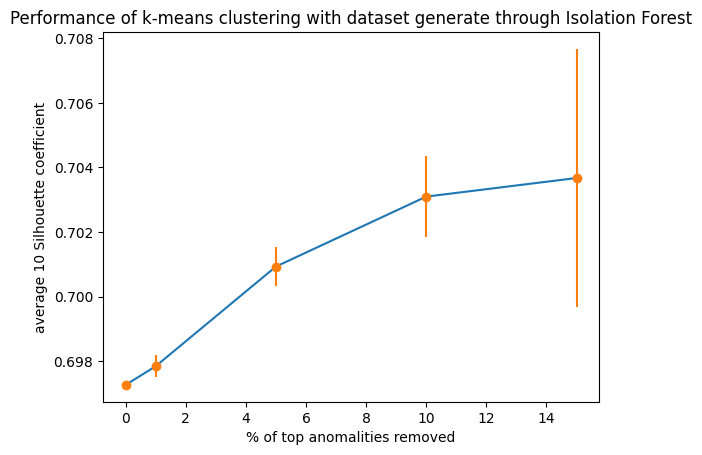

In [ ]:
x_axis = [0, 1, 5, 10, 15]
IF_axis = [IF_0_mean, IF_1_mean, IF_5_mean, IF_10_mean, IF_15_mean]
IF_err_axis = [IF_0_std, IF_1_std, IF_5_std, IF_10_std, IF_15_std]
plt.plot(x_axis, IF_axis)
plt.errorbar(x_axis, IF_axis, yerr = IF_err_axis, fmt ='o')
plt.xlabel("% of top anomalities removed")
plt.ylabel("average 10 Silhouette coefficient")
plt.title("Performance of k-means clustering with dataset generate through Isolation Forest")
plt.show()